# デモ実装（トピックの可視化）
## 環境構築
今回は必要なライブラリはこちらです。
- gensim
- scikit-learn
- umap-learn
- matplotlib
- numpy
- pandas

Mecabは使用しません。

### 準備
- ライブラリ
- 生データ・コーパス・辞書・モデルのロード
- プロット用関数

In [ ]:
# Colab専用、実行セル
# ランタイムのリスタートが必要な場合があります。
# RESTART RUNTIMEというボタンがあったら押して、「はい」を選択して、リスタートしてください。
!pip install --upgrade gensim
!pip install --upgrade numpy
!pip install umap-learn
!pip install --upgrade --no-cache-dir gdown


In [ ]:
# Colab専用、実行セル
# 必要なデータをダウンロードします。
!gdown "https://drive.google.com/uc?export=download&id=19geYOfD9eRuuDwlcQjBGypYjHAuWYntS"
!unzip Demo_TopicVis.zip

In [ ]:
prefix = "Demo_TopicVis"  # Colabの場合
# prefix = "."  # ローカルの場合

In [302]:
import numpy as np
import pandas as pd
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel, Word2Vec
from sklearn.manifold import TSNE  # 可視化用、次元削減を行う
from umap import UMAP  # 可視化用、次元削減を行う
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # プロット用の色

# 生データ・コーパス・辞書・モデルのロード
df = pd.read_csv("./raw_corpus.csv")
corpus = MmCorpus('./corpus.mm')
dict = Dictionary.load(f'./livedoor_demo.dict')
lda = LdaModel.load('./lda_demo.model')  # トピックモデル
w2v = Word2Vec.load('./word2vec.model')  # word2vecモデル

2023-02-09 22:46:08.864 INFO    gensim.corpora.indexedcorpus: loaded corpus index from ./corpus.mm.index
2023-02-09 22:46:08.865 INFO    gensim.corpora._mmreader: initializing cython corpus reader from ./corpus.mm
2023-02-09 22:46:08.866 INFO    gensim.corpora._mmreader: accepted corpus with 7367 documents, 39338 features, 935804 non-zero entries
2023-02-09 22:46:08.867 INFO    gensim.utils: loading Dictionary object from ./livedoor_demo.dict
2023-02-09 22:46:08.898 INFO    gensim.utils: Dictionary lifecycle event {'fname': './livedoor_demo.dict', 'datetime': '2023-02-09T22:46:08.898328', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'loaded'}
2023-02-09 22:46:08.925 INFO    gensim.utils: loading LdaModel object from ./lda_demo.model
2023-02-09 22:46:08.929 INFO    gensim.utils: loading expElogbeta from ./lda_demo.model.expElogbeta.npy with mmap=None
2023-02-09 22:46:08.

In [338]:
def plot_decomposition(x_vals, y_vals, labels):
    """次元削減後のベクトル（２次元）を散布図でプロットする
    """
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plt.figure(figsize=(12, 12))
    for i, l in enumerate(np.unique(labels)):
        x = x_vals[np.where(labels==l)]
        y = y_vals[np.where(labels==l)]
        plt.scatter(x, y, color=mycolors[i], label=l, alpha=0.3, s=100)
    plt.legend()

### トピックの可視化にチャレンジ
トピックごとには単語分布があります。このトピックの特徴は、この単語分布にあります。  
ということで、単語分布から単語をサンプリングしてみましょう。  

サンプリングされた単語集合は、それぞれのトピックの特徴を表現しているだろうと考えます。  
この単語集合をword2vecで単語ベクトルに変換して、次元削減で２次元に可視化することができます。  
この２次元の可視化がトピックの特徴を表現するかどうか、確認してみましょう。


In [347]:

class WordDitributions():
    """トピックモデルから各トピックが持つ単語分布を整形し、その単語分布から単語をサンプリングできるようにする。
    """
    def __init__(self, lda: LdaModel, k=10000, p=0.92):
        self.all_word_dist = self._prep(lda, k=10000, p=0.92)

    def sample(self, topic_n, n=10):
        """あるトピック（topic_n）の単語分布から、単語をn回サンプルする。
        """
        word_dist = [word[1] for word in self.all_word_dist[topic_n]]  # トピックの確率分布のみ抽出（単語ラベルを省く）
        # word_distで決まる多項分布を、n回分サンプルする
        rng = np.random.default_rng()
        samples = rng.multinomial(n, word_dist, size=1)  # list[int], len(samples)=単語分布の単語の数, 値：n回中の出現回数
        # 単語の出現回数に応じて、(word, probability)をその回数分、word_smaplesに格納する
        nonzero_index_array = np.argwhere(samples>0)
        samples = [(i[1], samples[0,i[1]]) for i in nonzero_index_array]
        word_samples = [self.all_word_dist[topic_n][item[0]] for item in samples for n in range(item[1])]
        return word_samples
    
    def _prep(self, lda: LdaModel, k=10000, p=0.92):
        """
        Args:
            lda: gensim.models.LdaModel
                学習済みのトピックモデル。このモデルの持つトピックごとの単語分布を抽出する
            k: int, optional
                単語分布を整形する際に、上位k個（Top-k）の単語に限定する。
            p: floar, optional
                単語分布を整形する際に、確率の合計がpになるまでの最小の単語に限定する。

        Returns:
            all_word_dist: list[list[tuple(str, float)]]
                単語とその確率を、トピックごとに格納
        """
        all_word_dist = []
        topics = lda.show_topics(
            formatted=False,  # (word, probability)を返す
            num_topics=lda.num_topics,  # 全トピック
            num_words=k  # 上位k単語
        )
        for topic in topics:
            count = 0
            word_p = []
            i = topic[0]
            for word in topic[1]:
                word_p.append(word)  # word: (単語, 確率）の確率が高い順に追加
                count += word[1]  # word weightを集計
                if count > p:  # 集計したword weightがpを超えた時
                    print(f"{i}番目のトピックの単語分布は, {len(word_p)}個の単語をもつ。閾値{p}<{count}")
                    sum = np.sum([p[1] for p in word_p])  # 確率分布にするための正規化
                    word_p = [(word[0], word[1]/sum) for word in word_p]
                    all_word_dist.append(word_p)
                    break
        return all_word_dist


In [348]:
sampler = WordDitributions(lda, p=0.3)

0番目のトピックの単語分布は, 4894個の単語をもつ。閾値0.92<0.9200204082517303
1番目のトピックの単語分布は, 6538個の単語をもつ。閾値0.92<0.9200193639662757
2番目のトピックの単語分布は, 5079個の単語をもつ。閾値0.92<0.9200104878509592
3番目のトピックの単語分布は, 3819個の単語をもつ。閾値0.92<0.9200141257570067
4番目のトピックの単語分布は, 2194個の単語をもつ。閾値0.92<0.920045419021335
5番目のトピックの単語分布は, 3869個の単語をもつ。閾値0.92<0.9200256160584104
6番目のトピックの単語分布は, 4812個の単語をもつ。閾値0.92<0.9200031815889815
7番目のトピックの単語分布は, 2204個の単語をもつ。閾値0.92<0.9200130103672564
8番目のトピックの単語分布は, 4209個の単語をもつ。閾値0.92<0.9200115677340364


In [367]:
N_SUMPLE = 30  # サンプル回数
word_topic_n = []  # トピック番号を格納
word_vectors = []  # 単語ベクトルを格納
count = 0
for topic_n in range(lda.num_topics):
    while count < N_SUMPLE:
        sample = sampler.sample(topic_n, 1)[0][0]
        try:
            # 単語ベクトルに変換、word2vecの辞書にない場合は例外処理（パス）
            word_vector = w2v.wv[sample]
        except KeyError as e:
            print(e)
        else:
            # 無事単語ベクトルに変換できたら格納。
            word_vectors.append(word_vector)
            word_topic_n.append(topic_n)
            count += 1
    count = 0

#### 次元削減
最近よく使われる二つの手法で可視化。どちらも同じ使い方ができます。
- tSNE
- UMAP

In [358]:
tsne_model = TSNE()
tsne_lda = tsne_model.fit_transform(np.array(word_vectors))

umap_model = UMAP()
umap_lda = umap_model.fit_transform(np.array(word_vectors))

#### プロット
- 各ベクトルを散布図でプロット
- トピックがラベル

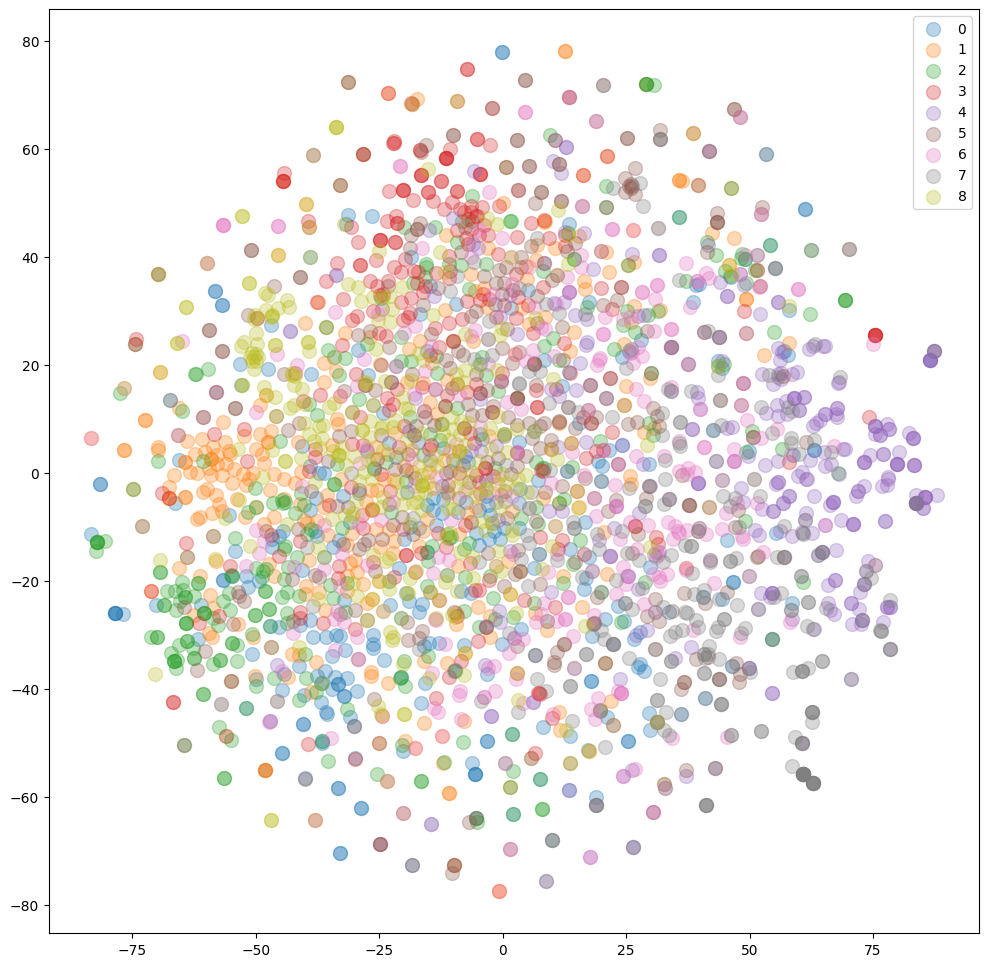

In [359]:
plot_decomposition(tsne_lda[:,0], tsne_lda[:,1], word_topic_n)

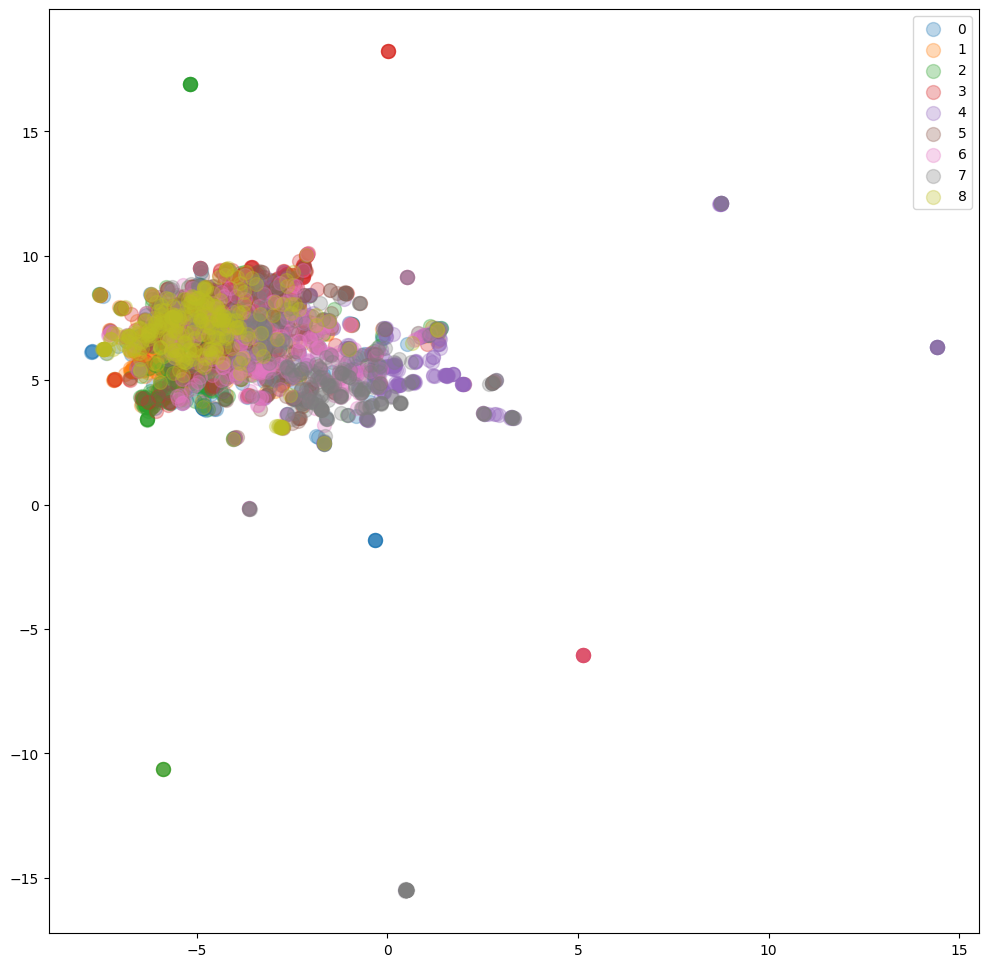

In [360]:
plot_decomposition(umap_lda[:,0], umap_lda[:,1], word_topic_n)

### 各ドキュメントに割り当てられたトピック分布を可視化
上記の可視化は、トピックごとの特徴を表現しているとは言えませんでした。  
特定のトピックの単語分布からサンプルしたという情報は、単語ベクトルに変換すると消失してしまったようです。  
次は、素直に、文書に割り当てられているトピック分布を可視化させてみます。

- トピック分布を文書のベクトルとみなす。今回は９次元のベクトル
- ２次元に次元削減をおこなって、プロットする

In [361]:
# トピックモデルを使って、コーパスにあるドキュメントを、トピックごとの確率を要素としたベクトルで表現する
# トピックの確率をベクトルとして取得
# row_list: (index, weight)はトピックごとの確率を持っているが、確率が1e-8以下のトピックは省かれている。
#   https://github.com/RaRe-Technologies/gensim/blob/f35faae7a7b0c3c8586fb61208560522e37e0e7e/gensim/models/ldamodel.py#L1359
topic_weights = []
for row_list in lda[corpus]:
    topic_weights.append([w for i, w in row_list])  
    
# 省かれたトピックの確率を0で穴埋め
arr = pd.DataFrame(topic_weights).fillna(0).values

topic_num = np.argmax(arr, axis=1)  # 各ドキュメントの最も確率の大きいトピック番号

#### 次元削減
最近よく使われる二つの手法で可視化。どちらも同じ使い方ができます。
- tSNE
- UMAP

In [362]:
tsne_model = TSNE()
tsne_lda = tsne_model.fit_transform(arr)

umap_model = UMAP()
umap_lda = umap_model.fit_transform(arr)

#### プロット
- 各ベクトルを散布図でプロット
- トピックがラベル

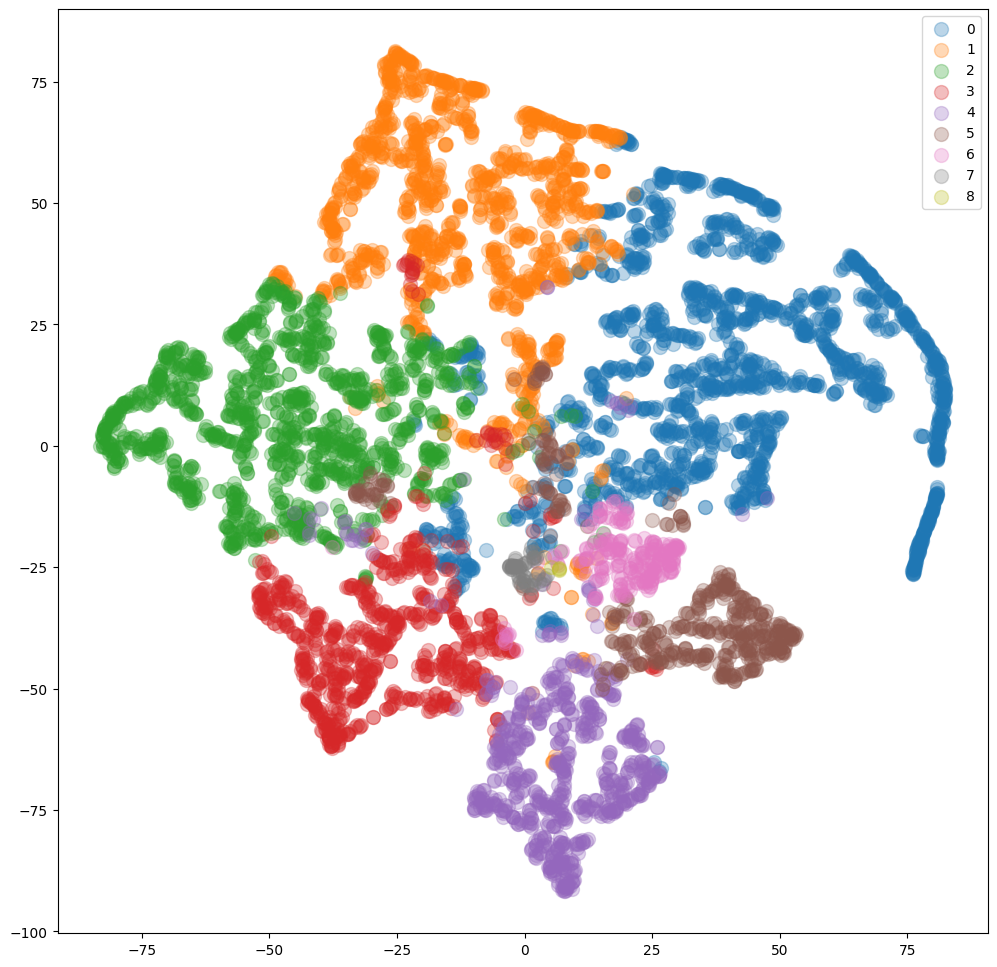

In [363]:
# tSNE
plot_decomposition(tsne_lda[:,0], tsne_lda[:,1], topic_num)

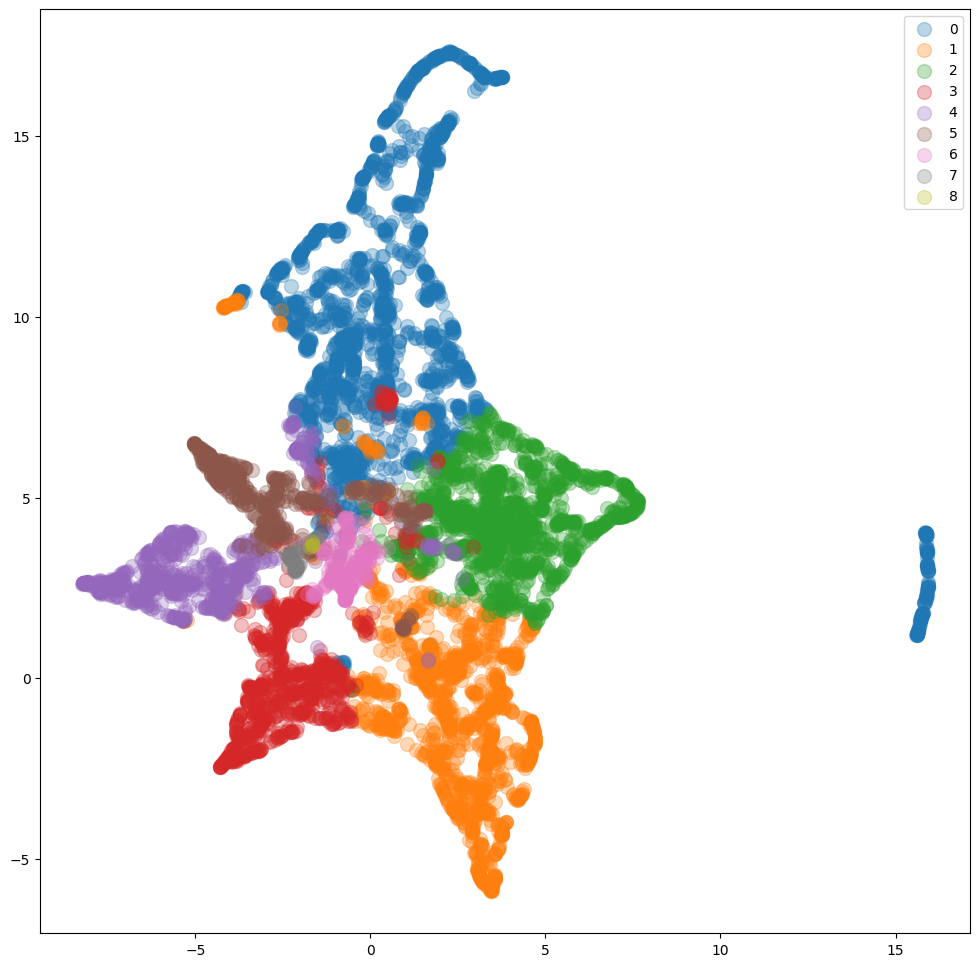

In [364]:
# UMAP
plot_decomposition(umap_lda[:,0], umap_lda[:,1], topic_num)

### ラベルを変えてみましょう
上記の可視化は確かにトピックを可視化しています。  
トピックは９種類で、文書ごとにそれぞれのトピックの割合を持ちます。  
ラベルはその中で最も割合の大きいトピックを割合としています。  
ですので、上記の可視化によって新しく得られる情報はあまりありません。  

文書が記事だったことを思い出して、ラベルを記事のカテゴリにしてみましょう。

In [334]:
topic_weights = []
labels = []
for i, row_list in enumerate(lda[corpus]):
    topic_weights.append([w for n, w in row_list])
    labels.append(df.iloc[i,0])

labels = np.array(labels)

# 省かれたトピックの確率を0で穴埋め
arr = pd.DataFrame(topic_weights).fillna(0).values

In [365]:
tsne_model = TSNE()
tsne_lda = tsne_model.fit_transform(arr)

umap_model = UMAP()
umap_lda = umap_model.fit_transform(arr)

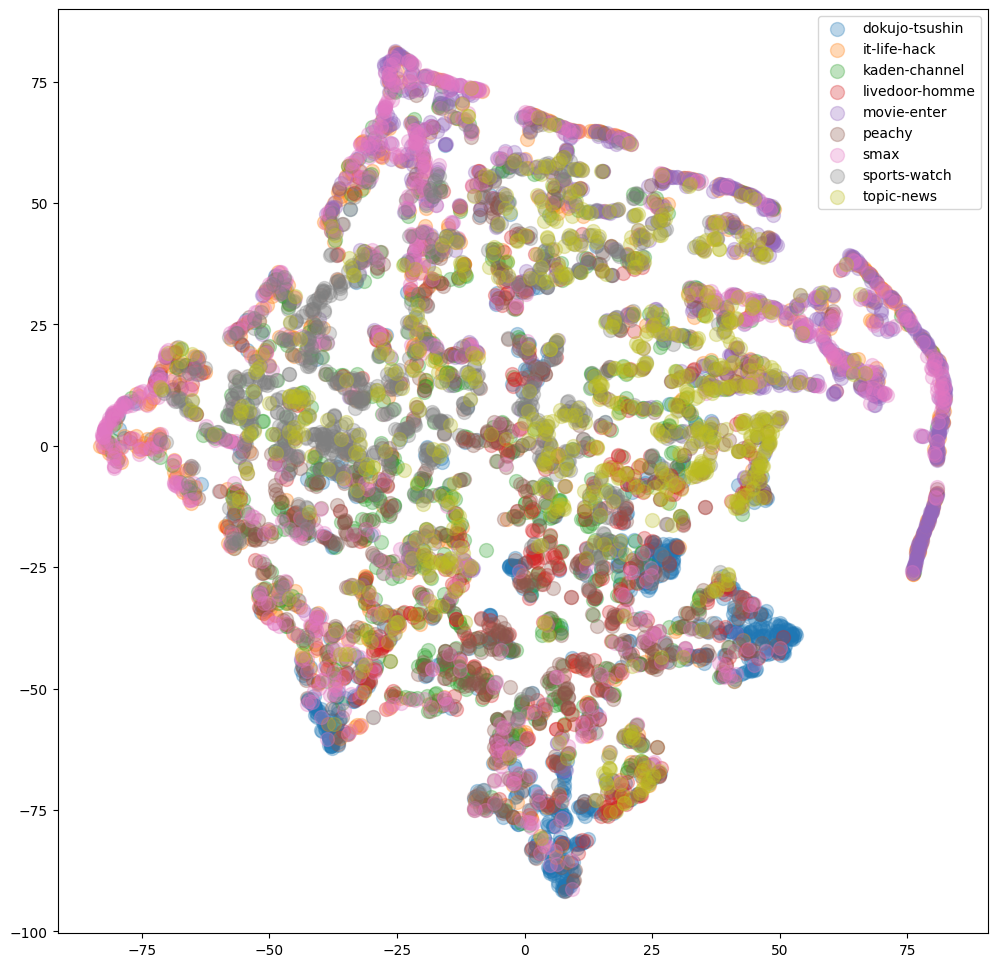

In [366]:
# tSNE
plot_decomposition(tsne_lda[:,0], tsne_lda[:,1], labels)

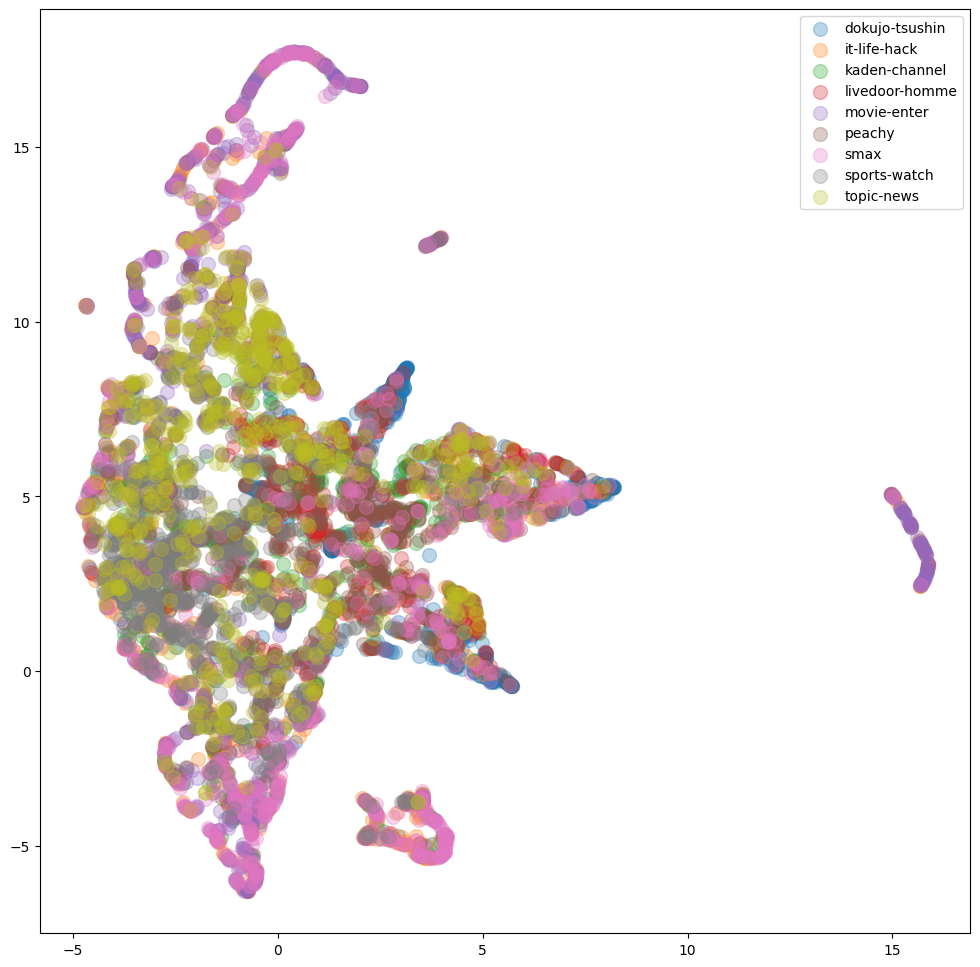

In [369]:
# UMAP
plot_decomposition(umap_lda[:,0], umap_lda[:,1], labels)

### 結局、どんな可視化がトピックの可視化に有効か
文書ごとのトピック分布の可視化は、そこそこ綺麗に可視化できているように見えました。  
しかし、これは文書がどのトピックに割り当てられているかがはっきり分かれている程度の情報しかありません。  
ラベルに記事のカテゴリ情報を追加してみても、新たな情報を得ることは期待できそうにありません。

もう少し、分析に効きそうな可視化を検討します。

- 課題：データはプロットしただけでは、ベクトルの表現がまともかどうか（学習が妥当か）くらいの確認しかできない
- 考察：
    - トピックモデルは文書のクラスタリングとしては機能している（ラベルとの一致度合いは別） 👉 トピックの位置関係には情報がある
    - トピックの情報は単語分布にある 👉 単語ベクトルは有効ではなかった。単語分布を直接確認してみる？
- 要求：トピックに対して、どんな単語で構成されているか確認しながらトピックの分布を見たい

👉 pyLDAvisという便利なライブラリがある

app.pyにstreamlitで、pyLDAvisを確認できます。  
ローカルで、`streamlit run app.py`で起動させてみましょう。